In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
from BispTools import BispTreeLevel, BispDelaunay

# Bin averaging the bispectrum with Delaunay interpolation

In the following we demonstrate the usage of the `BispDelaunay` module to produce bin averaged model predictions of the bispectrum. 

We begin by defining the bin width of the bispectrum measurements and the range of scales to be covered:

In [2]:
kf = 2*np.pi/1500.  # fundamental frequency for a box size of 1500 Mpc/h
dk = 2              # bin width for bispectrum measurements, in units of kf
kmin = 2            # minimum scale (at bin centre), in units of kf
kmax = 10           # maximum scale (at bin centre), in units of kf

With these values we can set up a new `BispDelaunay` object.

In [3]:
BDelaunay = BispDelaunay(kmin=kmin, kmax=kmax, dk=dk, kf=kf)

It generates a list of bispectrum triangle configurations with $k_1 \geq k_2 \geq k_3$ and $k_1 \leq k_2 + k_3$ with the first bin centred on $k_1 = k_{\rm min}$ and the last one on $k_1 = k_{\rm max}$ (currently does not include "open" triangle configurations). This list (in units of $k_f$) is assumed to match the one for which the bispectrum has been measured and is accessible through:

In [4]:
BDelaunay.tri  # list of k1, k2, k3 in units of kf

array([[ 2,  2,  2],
       [ 4,  2,  2],
       [ 4,  4,  2],
       [ 4,  4,  4],
       [ 6,  4,  2],
       [ 6,  4,  4],
       [ 6,  6,  2],
       [ 6,  6,  4],
       [ 6,  6,  6],
       [ 8,  4,  4],
       [ 8,  6,  2],
       [ 8,  6,  4],
       [ 8,  6,  6],
       [ 8,  8,  2],
       [ 8,  8,  4],
       [ 8,  8,  6],
       [ 8,  8,  8],
       [10,  6,  4],
       [10,  6,  6],
       [10,  8,  2],
       [10,  8,  4],
       [10,  8,  6],
       [10,  8,  8],
       [10, 10,  2],
       [10, 10,  4],
       [10, 10,  6],
       [10, 10,  8],
       [10, 10, 10]])

In order to decompose the integration volume for each triangle configuration into tetrahedra, we can adapt several options that specify the refinement levels for different types of configurations. That is useful because the binning effect is more significant for collinear configurations (including squeezed ones), and so one would like to use a larger refinement for them. In particular, we allow to define different refinement levels for approx. collinear triangles (using the condition $k_2 + k_3 < \eta_{\rm col}\,k_1$) or squeezed triangles (with the condition $k_3 < \eta_{\rm sq}\,(k_1+k_2)$), triangle configuraions that have a non-cubical integration volume (either $k_i = \Delta k$ or $|k_1 - k_2 - k_3| \leq \Delta k$), and all other configurations that do not fall into either category.

In [6]:
nsteps = [2,3,5]     # number of vertices per side for generic triangle configs (1st entry), configs with non-cubical integation volume (2nd entry), collinear/squeezed configs (3rd entry)
collinear_cut = 0.8  # eta_col used in the definition of collinear configurations
squeezed_cut = 0.05  # eta_sq used in the definition of squeezed configurations
midpoint = True      # determines whether the bin centre is included for generic triangle configs or not

BDelaunay.set_refinement_settings(nstep=nsteps, collinear_cut=collinear_cut, squeezed_cut=squeezed_cut, midpoint=midpoint)

Given these settings (the above values are the default - it is not necessary to set the settings explicitly unless different values are desired), we can compute the Delaunay matrix as follows. Depending on the number of triangle configurations and refinement settings this might take a while to compute...

In [18]:
BDelaunay.compute_Delaunay_matrix()

We now have a list of unique vertices (`BDelaunay.unique_vertices`, also in units of $k_f$) for all Delaunay tetrahedra, at which we need to evaluate the bispectrum in order to compute the bin average for the triangle configurations defined through `BDelaunay.tri`. We can also visualise how the integration volume for given triangle configurations has been decomposed into tetrahedra:

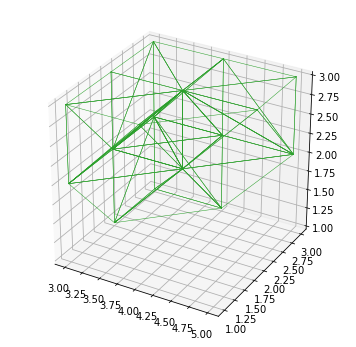

In [53]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

# plotting e.g. the second triangle configuration, corresponding to k1=4, k2=2, k3=2
BDelaunay.plot_simplices(tri_indices=np.arange(1,2), ax=ax)

Let us now generate a table with the bispectrum values at the vertices. As an example we make use of the simple `BispTreeLevel` module, which computes the three galaxy bias contributions to the real-space bispectrum. In particular, `BispTreeLvel.B211` returns a table with three columns corresponding to $2 F_2(\boldsymbol{k}_1,\boldsymbol{k}_2)\,P_L(k_1)\,P_L(k_2) + \mathrm{cyc.}$, $P_L(k_1)\,P_L(k_2) + \mathrm{cyc.}$ and $2 K(\boldsymbol{k}_1,\boldsymbol{k}_2)\,P_L(k_1)\,P_L(k_2) + \mathrm{cyc.}$

In [7]:
# initialise the module with a file storing the linear power spectrum in the format k, P_linear(k)
B = BispTreeLevel(fname_Plinear='sample_linear_power_spectrum.dat')

# compute tree-level bispectrum table evaluated at list of unique vertices
Btable_vertices = B.B211(BDelaunay.unique_vertices*kf)

It is also possible to export the list of vertices, so external codes can be used to evaluate the bispectrum.

In [29]:
BDelaunay.export_vertices(fname='unique_vertices.dat') # in units of kf

Once we have the table (the number of columns is irrelevant, but the number of rows should match the number of unique vertices), we can initialise the `BDelaunay` object:

In [9]:
BDelaunay.init_vertices(table=Btable_vertices)

Executing `BDelaunay.Btable_delaunay` then returns the bin averaged values for each column of the provided table for a given triangle index (or list) from `BDelaunay.tri`.

In [10]:
# e.g. the full list
B211_delaunay = BDelaunay.Btable_delaunay(np.arange(BDelaunay.tri.shape[0]))

The corresponding estimates just using the centre of the bin are given by

In [11]:
B211 = B.B211(BDelaunay.tri*kf)

Comparing the two shows the impact of the bin average:

Text(0,0.5,'$B\\;[b_1^2 \\gamma_2]$')

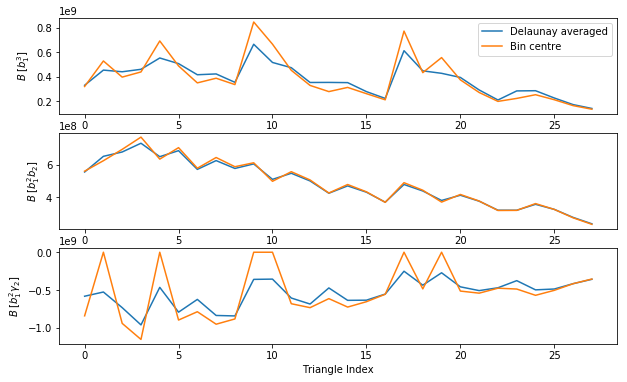

In [12]:
f = plt.figure(figsize=(10,6))
ax1 = f.add_subplot(311)
ax2 = f.add_subplot(312)
ax3 = f.add_subplot(313)

Ntri = BDelaunay.tri.shape[0]
ax1.plot(np.arange(Ntri),B211_delaunay[:,0],label='Delaunay averaged')
ax1.plot(np.arange(Ntri),B211[:,0],label='Bin centre')
ax2.plot(np.arange(Ntri),B211_delaunay[:,1])
ax2.plot(np.arange(Ntri),B211[:,1])
ax3.plot(np.arange(Ntri),B211_delaunay[:,2])
ax3.plot(np.arange(Ntri),B211[:,2])

ax1.legend()
ax3.set_xlabel('Triangle Index')
ax1.set_ylabel('$B\;[b_1^3]$')
ax2.set_ylabel('$B\;[b_1^2 b_2]$')
ax3.set_ylabel('$B\;[b_1^2 \gamma_2]$')

Since the Delaunay matrix is independent of cosmology, once it has been computed for a given bin width and refinement settings, it does not have to be generated again. It can therefore be exported in the compressed sparse row (CSR) format:

In [50]:
# fname_base provides the file root, three files with extensions "_v.dat", "_row_index.dat" and "_col_index.dat" are created
BDelaunay.export_Delaunay_matrix_as_CSR(fname_base='Delaunay_matrix_dk_2_kmin_2_kmax_10')

These files can be used at a later stage to re-initialise the `BDelaunay` object without having to compute the Delaunay matrix again.

In [13]:
BDelaunay_new = BispDelaunay(kmin=kmin, kmax=kmax, dk=dk, kf=kf)
BDelaunay_new.init_Delaunay_matrix_from_file(fname_base='Delaunay_matrix_dk_2_kmin_2_kmax_10')